In [1]:
import tensorflow as tf
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Train
with open("data/X_train_scaled.pickle", 'rb') as xtrain, open("data/y_train_scaled.pickle", 'rb') as ytrain:
    X_train, y_train = pickle.load(xtrain), pickle.load(ytrain)

# Test
with open("data/X_test_scaled.pickle", 'rb') as xtest, open("data/y_test_scaled.pickle", 'rb') as ytest:
    X_test, y_test = pickle.load(xtest), pickle.load(ytest)

## Declare fews variables

In [3]:
n_epochs = 200
learning_rate = .0001

# Deep Feed Forward
## Define DFF model using keras
1 input layer  - 6 neurons
1 hidden layer - 64 neurons, relu activation
1 output layer - 1 neuron, linear activation

Dropout layer is used to reduce overfitting and improve the training preformace by desactivating 20% of the neurons. Not useful in this model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, input_dim=6, kernel_initializer='normal'),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='mean_squared_error')
              #metrics=['mae', 'mape'])

hist = model.fit(X_train, y_train, validation_split=.2, epochs=n_epochs, verbose=0)

In [5]:
mse = model.evaluate(X_test, y_test)
print(f"loss test set (mse): {mse}")

128/128 [==============================] - 0s 610us/step - loss: 0.0213
loss test set (mse): 0.021304666996002197


<AxesSubplot:title={'center':'Learning Curves: loss according to the number of epochs'}>

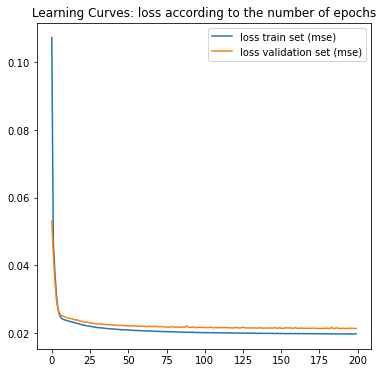

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Learning Curves: loss according to the number of epochs")
sns.lineplot(x=range(n_epochs), y=hist.history["loss"], label="loss train set (mse)", ax=ax)
sns.lineplot(x=range(n_epochs), y=hist.history["val_loss"], label="loss validation set (mse)", ax=ax)

In [7]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

print(f"R2 score {r2_score(y_test, y_pred)}")

R2 score 0.6335380918292666


# Recurent Neural Network
## Define RNN model using keras to try the regression with another architecture
1 input layer  - 6 neurons
2 hidden layer - GRU - SimpleRNN
1 output layer - 1 neuron, linear activation

Dropout layer is used to reduce overfitting and improve the training preformance by desactivating 20% of the neurons each batch.

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(6, input_shape=(6, 1)))
tf.keras.layers.Dropout(0.2),
model.add(tf.keras.layers.GRU(64, return_sequences=True))
tf.keras.layers.Dropout(0.2),
model.add(tf.keras.layers.SimpleRNN(64))
tf.keras.layers.Dropout(0.2),
model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='mean_squared_error')
hist = model.fit(X_train, y_train, validation_split=.2, epochs=n_epochs, verbose=0)

In [9]:
mse = model.evaluate(X_test, y_test)
print(f"loss test set (mse): {mse}")

128/128 [==============================] - 0s 1ms/step - loss: 0.0214
loss test set (mse): 0.021357759833335876


<AxesSubplot:title={'center':'Learning Curves: loss according to the number epochs'}>

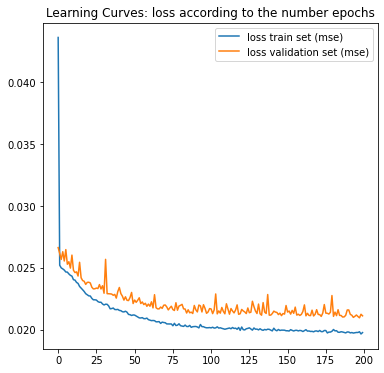

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Learning Curves: loss according to the number epochs")
sns.lineplot(x=range(n_epochs), y=hist.history["loss"], label="loss train set (mse)", ax=ax)
sns.lineplot(x=range(n_epochs), y=hist.history["val_loss"], label="loss validation set (mse)", ax=ax)

In [11]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

print(f"R2 score {r2_score(y_test, y_pred)}")

R2 score 0.6326250586925859


___

## Implementation of features selection with Boruta and declaration of a new model

In [12]:
import pandas as pd
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [13]:
df = pd.read_csv('data/housing.csv').dropna()

X = pd.get_dummies(df.drop("median_house_value", axis=1))
y = df["median_house_value"]

X['total_rooms'] = X['total_rooms'] / X['households']
X['total_bedrooms'] = X['total_bedrooms'] / X['households']
X['population'] = X['population'] / X['households']
X = X.drop('households', axis=1)

In [14]:
randomForest = RandomForestRegressor(n_jobs=-1, oob_score=True)
randomForest.fit(X, y)

RandomForestRegressor(n_jobs=-1, oob_score=True)

In [15]:
feature_selection = BorutaPy(randomForest, n_estimators='auto', verbose=0, random_state=16)
feature_selection.fit(np.array(X), np.array(y))

BorutaPy(estimator=RandomForestRegressor(n_estimators=48, n_jobs=-1,
                                         oob_score=True,
                                         random_state=RandomState(MT19937) at 0x1DBB658F940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1DBB658F940)

In [16]:
feature_selection.transform(np.array(X))

# Creating list of varibale name, ranks, and final decision using zip
feature_rankings = list(zip(X.columns,
                            feature_selection.ranking_,
                            feature_selection.support_))

# Printing the list of varibales which got selected
count = 0
for i in feature_rankings:
    if i[2] == True:
        count += 1
        print(f'count: {count}  Name: {i[0]} Rank: {i[1]}')

count: 1  Name: longitude Rank: 1
count: 2  Name: latitude Rank: 1
count: 3  Name: housing_median_age Rank: 1
count: 4  Name: total_rooms Rank: 1
count: 5  Name: total_bedrooms Rank: 1
count: 6  Name: population Rank: 1
count: 7  Name: median_income Rank: 1
count: 8  Name: ocean_proximity_INLAND Rank: 1


### Only the houseHolds feature is eliminated by the feature selection of Boruta

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [18]:
normalizer_layer = tf.keras.layers.Normalization(input_dim=12, axis=None)
normalizer_layer.adapt(X_train.values)

model = tf.keras.models.Sequential([
    normalizer_layer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.008),
              loss='mean_squared_error')
#metrics=['mae', 'mape'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               3         
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 32)                416       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                      

In [20]:
hist = model.fit(X_train, y_train, validation_split=.2, epochs=int(n_epochs/4), verbose=0)

128/128 [==============================] - 0s 614us/step - loss: 4583887872.0000
loss test set (mse): 4583887872.0


<AxesSubplot:title={'center':'Learning Curves: loss according to the number epochs'}>

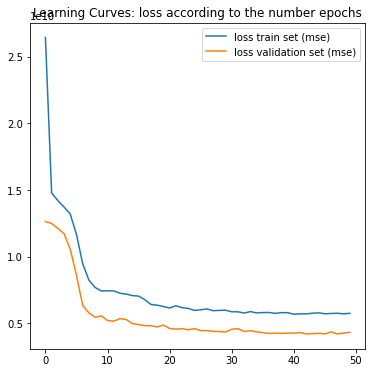

In [21]:
mse = model.evaluate(X_test, y_test)
print(f"loss test set (mse): {mse}")
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Learning Curves: loss according to the number epochs")
sns.lineplot(x=range(int(n_epochs/4)), y=hist.history["loss"], label="loss train set (mse)", ax=ax)
sns.lineplot(x=range(int(n_epochs/4)), y=hist.history["val_loss"], label="loss validation set (mse)", ax=ax)

In [22]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

print(f"R2 score {r2_score(y_test, y_pred)}")

R2 score 0.6557352064701554


### This is with this setup:
#### - Improvement of the features selection
#### - 3 hidden layer (32, 32, 16), learning_rate=0.009, n_epochs=50 that results are the best (highest r2, lowest mse) without overfitting
### But results are not that good as ML model such as Boosting Gradient Regressor. In this context it's more suitable to use ML instead of DL for simplicity of the implementation and better results.